In [1]:
!pip install opendatasets

In [2]:
import opendatasets as od
od.download('https://www.kaggle.com/datasets/kushagratandon12/diabetic-retinopathy-balanced', force = True)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: talhanaveed00
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/kushagratandon12/diabetic-retinopathy-balanced


100%|██████████| 1.90G/1.90G [01:26<00:00, 23.7MB/s]


In [14]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from transformers import ViTForImageClassification
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt
import shap
import pandas as pd

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [5]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [6]:
# Loading Dataset
train_dataset = datasets.ImageFolder(root='/content/diabetic-retinopathy-balanced/content/Diabetic_Balanced_Data/train', transform=transform)
val_dataset = datasets.ImageFolder(root='/content/diabetic-retinopathy-balanced/content/Diabetic_Balanced_Data/val', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)

In [7]:
model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224", num_labels=5, ignore_mismatched_sizes=True
)
model.to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([5]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([5, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
scaler = torch.cuda.amp.GradScaler()

<ipython-input-8-39165d37fbef>:3: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


In [16]:
def train(model, train_loader, val_loader, epochs=10):
    training_results = []
    for epoch in range(epochs):
        model.train()
        total_loss, correct = 0, 0
        all_preds, all_labels = [], []

        for images, labels in train_loader:
            images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            optimizer.zero_grad()

            with torch.cuda.amp.autocast():
                outputs = model(images).logits
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            total_loss += loss.item()
            preds = outputs.argmax(1)
            correct += (preds == labels).sum().item()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        train_acc = correct / len(train_loader.dataset)
        train_f1 = f1_score(all_labels, all_preds, average='weighted')
        train_precision = precision_score(all_labels, all_preds, average='weighted')
        train_recall = recall_score(all_labels, all_preds, average='weighted')

        print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader)}, Train Accuracy: {train_acc:.4f}")
        print(f"Precision: {train_precision:.4f}, Recall: {train_recall:.4f}, F1-score: {train_f1:.4f}")

        training_results.append([epoch+1, total_loss/len(train_loader), train_acc, train_precision, train_recall, train_f1])
        test(model, val_loader)

    df_train = pd.DataFrame(training_results, columns=['Epoch', 'Loss', 'Accuracy', 'Precision', 'Recall', 'F1-score'])
    df_train.to_csv("/content/training_results.csv", index=False)

In [17]:
def test(model, val_loader):
    model.eval()
    correct, total = 0, 0
    all_preds, all_labels = [], []
    classification_results = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            outputs = model(images).logits
            predictions = outputs.argmax(1)
            correct += (predictions == labels).sum().item()
            total += labels.size(0)
            all_preds.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            for i in range(len(labels)):
                classification_results.append([labels[i].item(), predictions[i].item()])

    accuracy = correct / total
    f1 = f1_score(all_labels, all_preds, average='weighted')
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')

    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")

    df_classification = pd.DataFrame(classification_results, columns=['Actual', 'Predicted'])
    df_classification.to_csv("/content/classification_results.csv", index=False)

    visualize_gradcam(model, val_loader)

In [18]:
# Grad-CAM Visualization
def visualize_gradcam(model, dataloader):
    images, labels = next(iter(dataloader))
    images, labels = images.to(device), labels.to(device)

    model.eval()
    outputs = model(images).logits
    predictions = outputs.argmax(1)

    fig, axes = plt.subplots(1, 5, figsize=(15, 5))
    for i in range(5):
        img = images[i].cpu().permute(1, 2, 0).numpy()
        axes[i].imshow(img)
        axes[i].set_title(f"Pred: {predictions[i].item()}, Actual: {labels[i].item()}")
        axes[i].axis("off")
    plt.show()

In [19]:
def shap_explain(model, dataloader):
    model.eval()
    batch = next(iter(dataloader))[0][:10].to(device)
    explainer = shap.GradientExplainer(model, batch)
    shap_values = explainer.shap_values(batch)
    shap.image_plot(shap_values, batch.cpu().numpy())

<ipython-input-16-c8973a210c34>:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 1, Loss: 0.6264778414522024, Train Accuracy: 0.7314
Precision: 0.7343, Recall: 0.7314, F1-score: 0.7321
Test Accuracy: 0.7265
Precision: 0.7345, Recall: 0.7265, F1-score: 0.7257


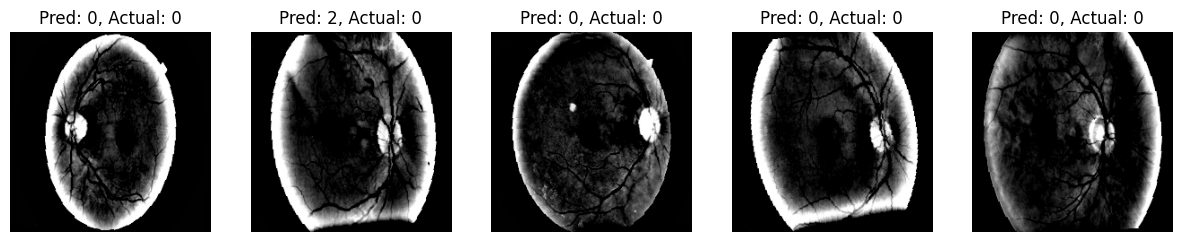

<ipython-input-16-c8973a210c34>:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 2, Loss: 0.5188743479769019, Train Accuracy: 0.7806
Precision: 0.7827, Recall: 0.7806, F1-score: 0.7812
Test Accuracy: 0.7458
Precision: 0.7498, Recall: 0.7458, F1-score: 0.7449


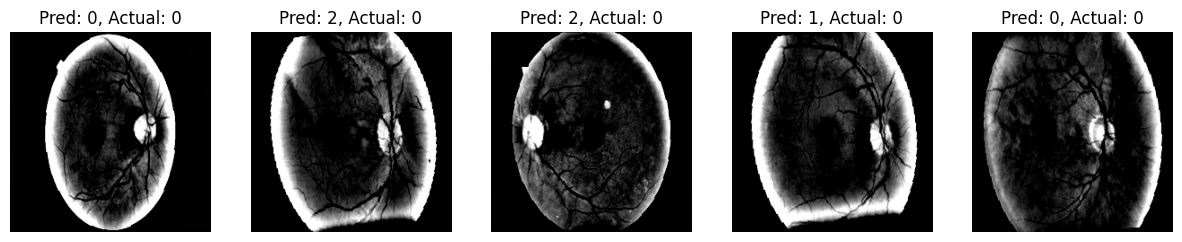

<ipython-input-16-c8973a210c34>:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 3, Loss: 0.430730421698707, Train Accuracy: 0.8200
Precision: 0.8216, Recall: 0.8200, F1-score: 0.8204
Test Accuracy: 0.7710
Precision: 0.7810, Recall: 0.7710, F1-score: 0.7703


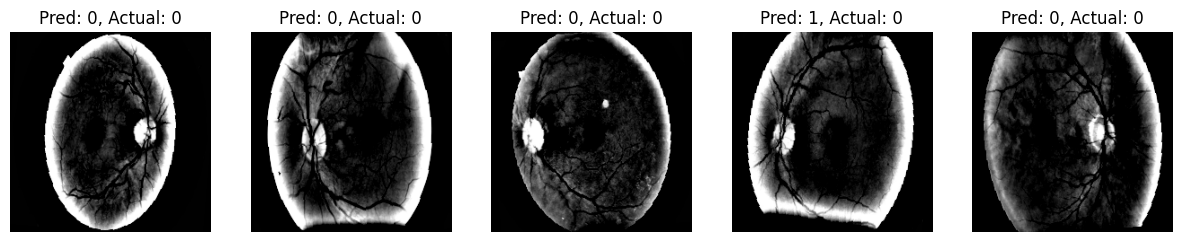

<ipython-input-16-c8973a210c34>:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 4, Loss: 0.34441736850010995, Train Accuracy: 0.8594
Precision: 0.8604, Recall: 0.8594, F1-score: 0.8597
Test Accuracy: 0.7863
Precision: 0.7836, Recall: 0.7863, F1-score: 0.7838


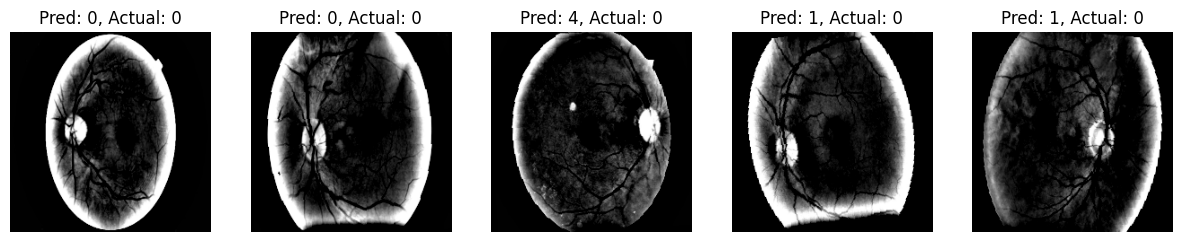

<ipython-input-16-c8973a210c34>:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 5, Loss: 0.2715579236528891, Train Accuracy: 0.8928
Precision: 0.8933, Recall: 0.8928, F1-score: 0.8929
Test Accuracy: 0.8006
Precision: 0.7993, Recall: 0.8006, F1-score: 0.7989


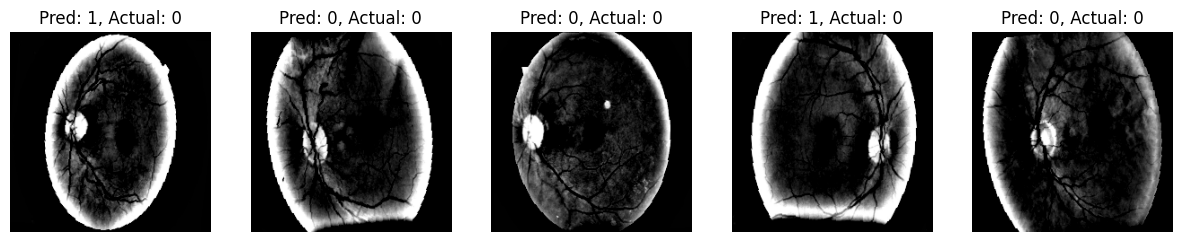

<ipython-input-16-c8973a210c34>:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 6, Loss: 0.2146825962152113, Train Accuracy: 0.9179
Precision: 0.9182, Recall: 0.9179, F1-score: 0.9180
Test Accuracy: 0.8160
Precision: 0.8164, Recall: 0.8160, F1-score: 0.8148


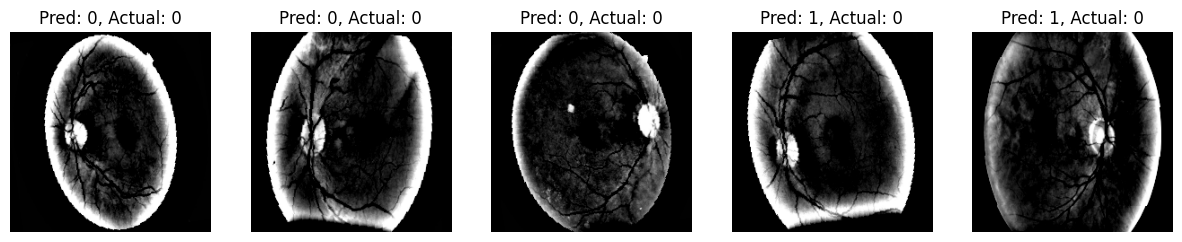

<ipython-input-16-c8973a210c34>:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 7, Loss: 0.16580025275813087, Train Accuracy: 0.9369
Precision: 0.9372, Recall: 0.9369, F1-score: 0.9370
Test Accuracy: 0.8263
Precision: 0.8252, Recall: 0.8263, F1-score: 0.8249


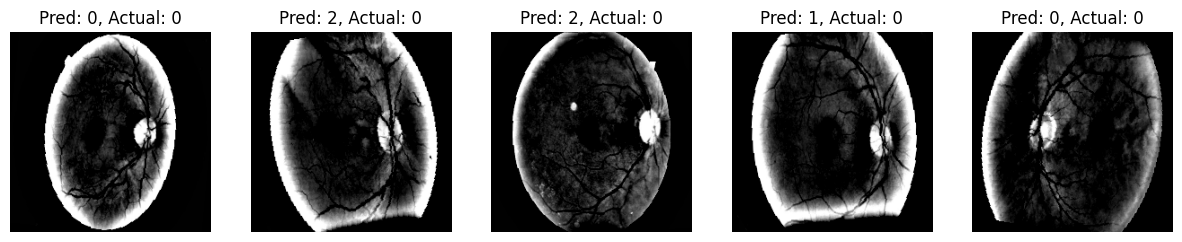

<ipython-input-16-c8973a210c34>:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 8, Loss: 0.13356690380982505, Train Accuracy: 0.9513
Precision: 0.9514, Recall: 0.9513, F1-score: 0.9513
Test Accuracy: 0.8263
Precision: 0.8263, Recall: 0.8263, F1-score: 0.8261


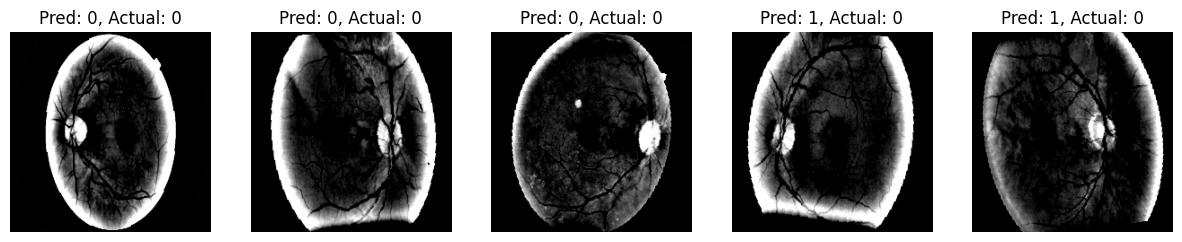

<ipython-input-16-c8973a210c34>:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 9, Loss: 0.11323389083297704, Train Accuracy: 0.9575
Precision: 0.9575, Recall: 0.9575, F1-score: 0.9575
Test Accuracy: 0.8397
Precision: 0.8465, Recall: 0.8397, F1-score: 0.8419


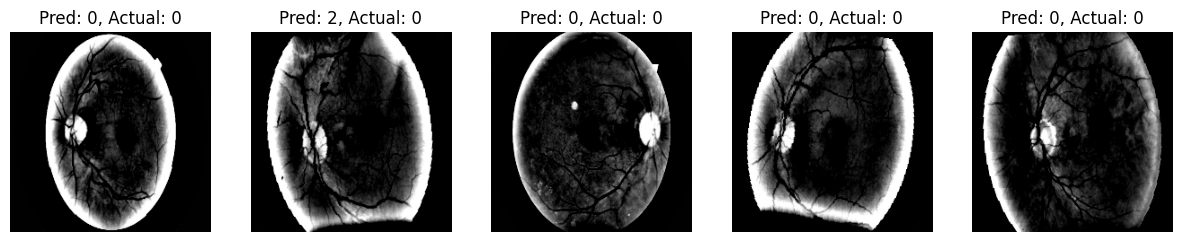

<ipython-input-16-c8973a210c34>:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 10, Loss: 0.08751846779041979, Train Accuracy: 0.9678
Precision: 0.9678, Recall: 0.9678, F1-score: 0.9678
Test Accuracy: 0.8436
Precision: 0.8419, Recall: 0.8436, F1-score: 0.8421


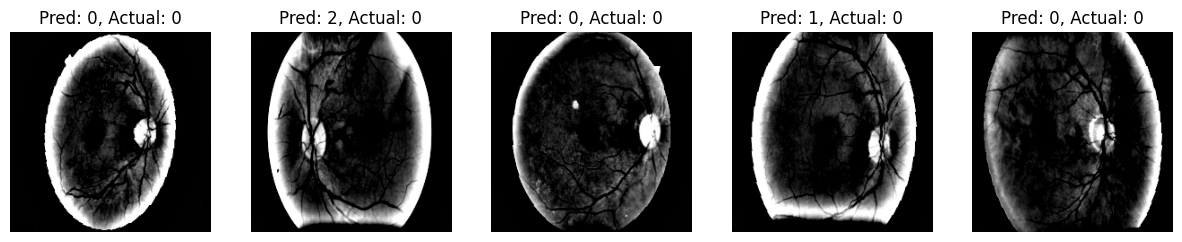

<ipython-input-16-c8973a210c34>:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 11, Loss: 0.08783155935816467, Train Accuracy: 0.9683
Precision: 0.9683, Recall: 0.9683, F1-score: 0.9683
Test Accuracy: 0.8336
Precision: 0.8400, Recall: 0.8336, F1-score: 0.8323


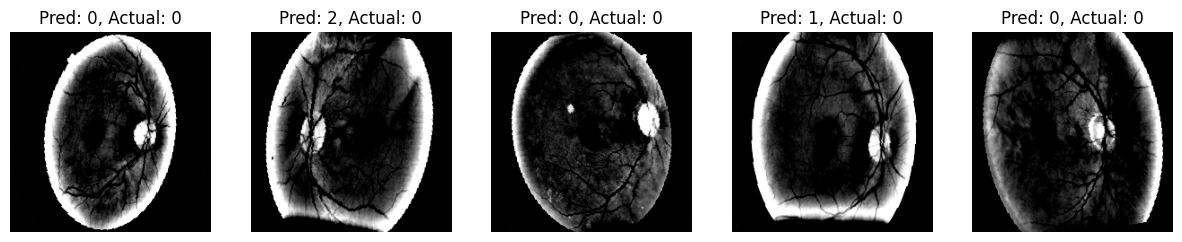

<ipython-input-16-c8973a210c34>:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 12, Loss: 0.07343456586001113, Train Accuracy: 0.9733
Precision: 0.9733, Recall: 0.9733, F1-score: 0.9733
Test Accuracy: 0.8505
Precision: 0.8483, Recall: 0.8505, F1-score: 0.8490


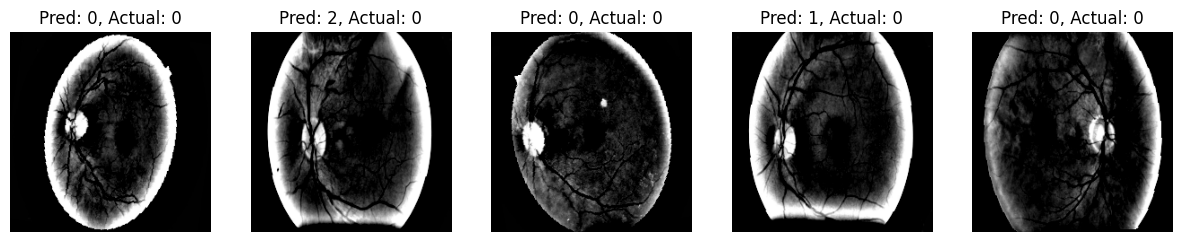

<ipython-input-16-c8973a210c34>:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 13, Loss: 0.05983019189101041, Train Accuracy: 0.9791
Precision: 0.9791, Recall: 0.9791, F1-score: 0.9791
Test Accuracy: 0.8327
Precision: 0.8474, Recall: 0.8327, F1-score: 0.8337


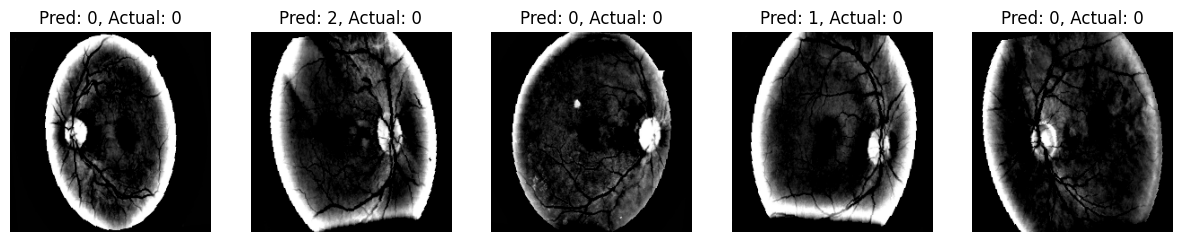

<ipython-input-16-c8973a210c34>:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 14, Loss: 0.0664809177910416, Train Accuracy: 0.9765
Precision: 0.9765, Recall: 0.9765, F1-score: 0.9765
Test Accuracy: 0.8560
Precision: 0.8592, Recall: 0.8560, F1-score: 0.8569


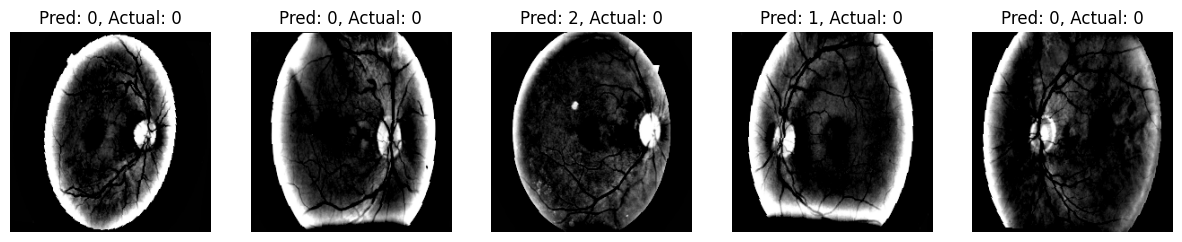

<ipython-input-16-c8973a210c34>:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 15, Loss: 0.05152390747646089, Train Accuracy: 0.9816
Precision: 0.9816, Recall: 0.9816, F1-score: 0.9816
Test Accuracy: 0.8557
Precision: 0.8553, Recall: 0.8557, F1-score: 0.8544


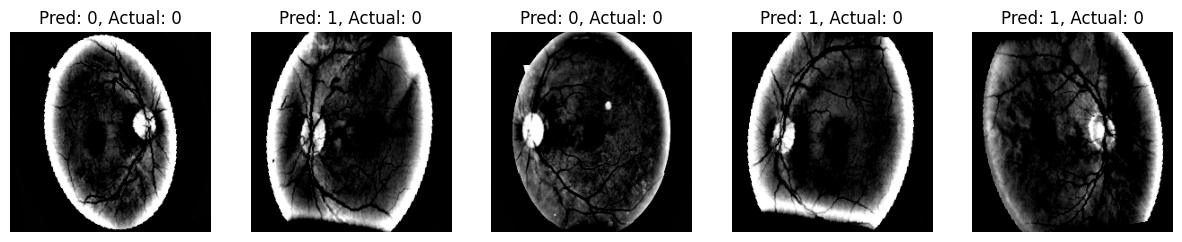

<ipython-input-16-c8973a210c34>:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 16, Loss: 0.05487189068020705, Train Accuracy: 0.9807
Precision: 0.9807, Recall: 0.9807, F1-score: 0.9807
Test Accuracy: 0.8586
Precision: 0.8582, Recall: 0.8586, F1-score: 0.8581


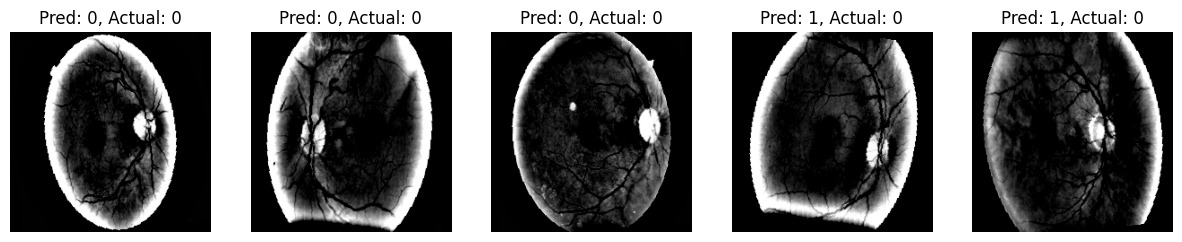

<ipython-input-16-c8973a210c34>:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 17, Loss: 0.045991777195869124, Train Accuracy: 0.9842
Precision: 0.9843, Recall: 0.9842, F1-score: 0.9843
Test Accuracy: 0.8426
Precision: 0.8420, Recall: 0.8426, F1-score: 0.8388


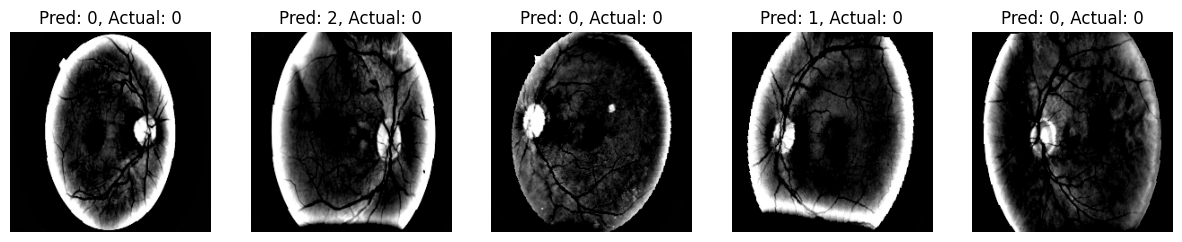

<ipython-input-16-c8973a210c34>:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 18, Loss: 0.05106481381089372, Train Accuracy: 0.9811
Precision: 0.9811, Recall: 0.9811, F1-score: 0.9811
Test Accuracy: 0.8601
Precision: 0.8597, Recall: 0.8601, F1-score: 0.8586


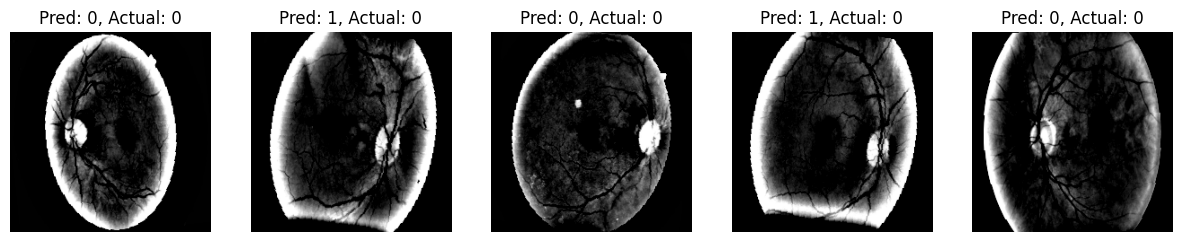

<ipython-input-16-c8973a210c34>:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 19, Loss: 0.05112535934826797, Train Accuracy: 0.9816
Precision: 0.9816, Recall: 0.9816, F1-score: 0.9816
Test Accuracy: 0.8547
Precision: 0.8531, Recall: 0.8547, F1-score: 0.8529


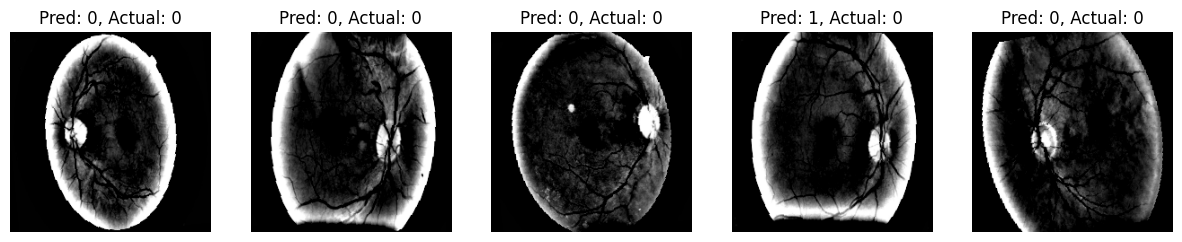

<ipython-input-16-c8973a210c34>:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 20, Loss: 0.039994302681674636, Train Accuracy: 0.9861
Precision: 0.9862, Recall: 0.9861, F1-score: 0.9862
Test Accuracy: 0.8612
Precision: 0.8607, Recall: 0.8612, F1-score: 0.8582


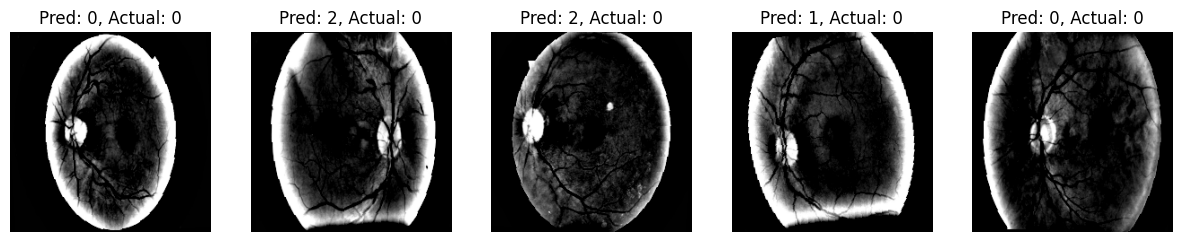

<ipython-input-16-c8973a210c34>:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 21, Loss: 0.040064268002478295, Train Accuracy: 0.9866
Precision: 0.9866, Recall: 0.9866, F1-score: 0.9866
Test Accuracy: 0.8608
Precision: 0.8601, Recall: 0.8608, F1-score: 0.8602


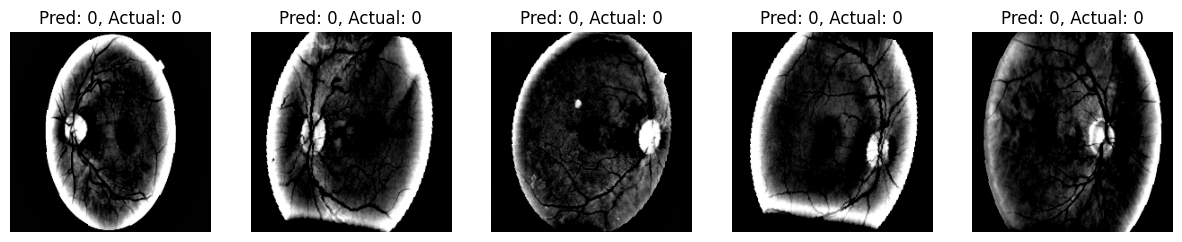

<ipython-input-16-c8973a210c34>:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 22, Loss: 0.03687485873610165, Train Accuracy: 0.9874
Precision: 0.9874, Recall: 0.9874, F1-score: 0.9874
Test Accuracy: 0.8525
Precision: 0.8523, Recall: 0.8525, F1-score: 0.8485


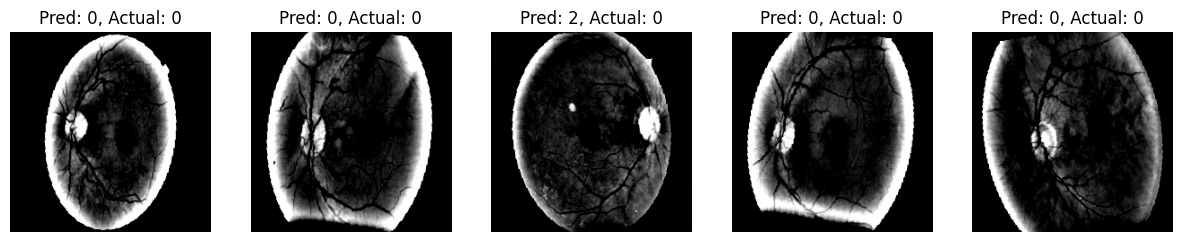

<ipython-input-16-c8973a210c34>:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 23, Loss: 0.037606175992336566, Train Accuracy: 0.9867
Precision: 0.9868, Recall: 0.9867, F1-score: 0.9868
Test Accuracy: 0.8626
Precision: 0.8602, Recall: 0.8626, F1-score: 0.8607


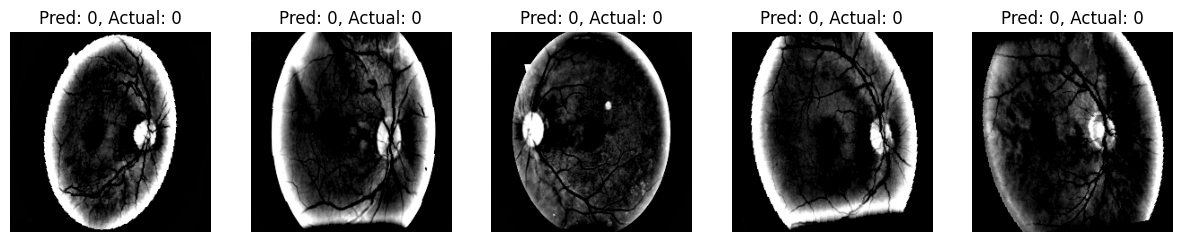

<ipython-input-16-c8973a210c34>:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 24, Loss: 0.038450684312813205, Train Accuracy: 0.9865
Precision: 0.9865, Recall: 0.9865, F1-score: 0.9865
Test Accuracy: 0.8572
Precision: 0.8559, Recall: 0.8572, F1-score: 0.8564


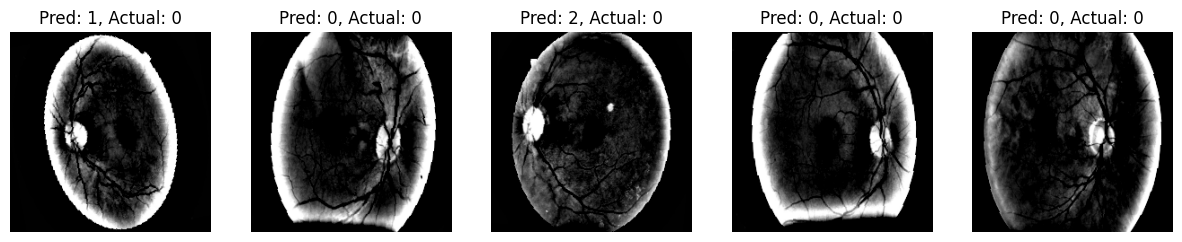

<ipython-input-16-c8973a210c34>:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 25, Loss: 0.039154737229075504, Train Accuracy: 0.9861
Precision: 0.9861, Recall: 0.9861, F1-score: 0.9861
Test Accuracy: 0.8686
Precision: 0.8701, Recall: 0.8686, F1-score: 0.8682


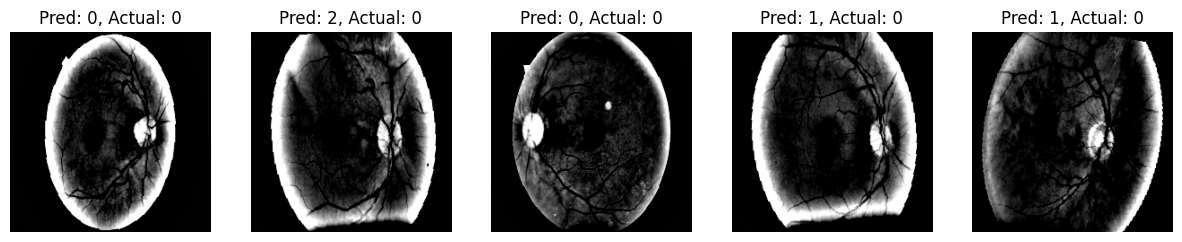

<ipython-input-16-c8973a210c34>:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 26, Loss: 0.03613704361144782, Train Accuracy: 0.9880
Precision: 0.9880, Recall: 0.9880, F1-score: 0.9880
Test Accuracy: 0.8643
Precision: 0.8613, Recall: 0.8643, F1-score: 0.8622


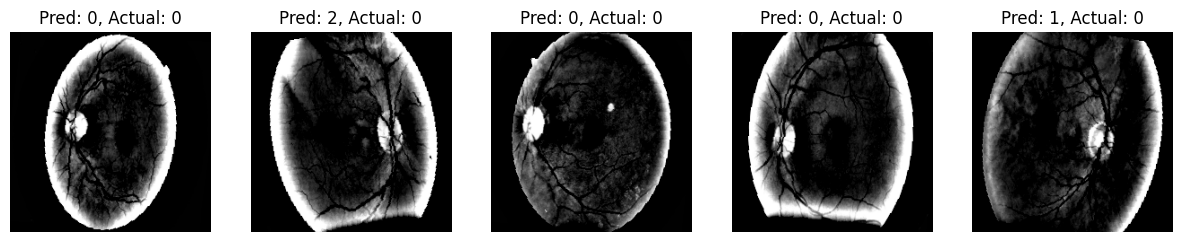

<ipython-input-16-c8973a210c34>:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 27, Loss: 0.03201601494990481, Train Accuracy: 0.9893
Precision: 0.9893, Recall: 0.9893, F1-score: 0.9893
Test Accuracy: 0.8687
Precision: 0.8694, Recall: 0.8687, F1-score: 0.8688


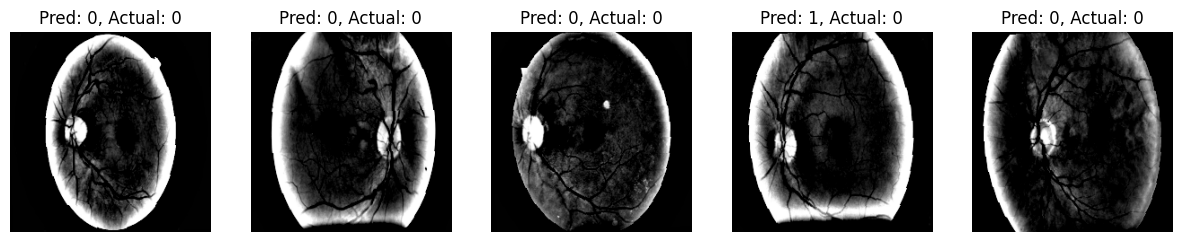

<ipython-input-16-c8973a210c34>:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 28, Loss: 0.03175382865318919, Train Accuracy: 0.9886
Precision: 0.9886, Recall: 0.9886, F1-score: 0.9886
Test Accuracy: 0.8689
Precision: 0.8721, Recall: 0.8689, F1-score: 0.8684


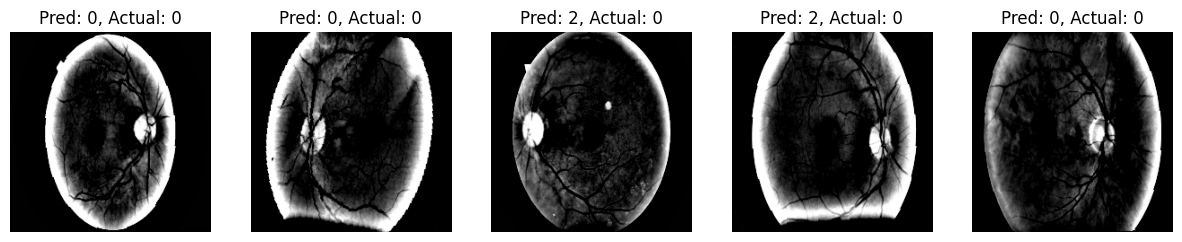

<ipython-input-16-c8973a210c34>:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 29, Loss: 0.03183225047199384, Train Accuracy: 0.9891
Precision: 0.9891, Recall: 0.9891, F1-score: 0.9891
Test Accuracy: 0.8730
Precision: 0.8723, Recall: 0.8730, F1-score: 0.8725


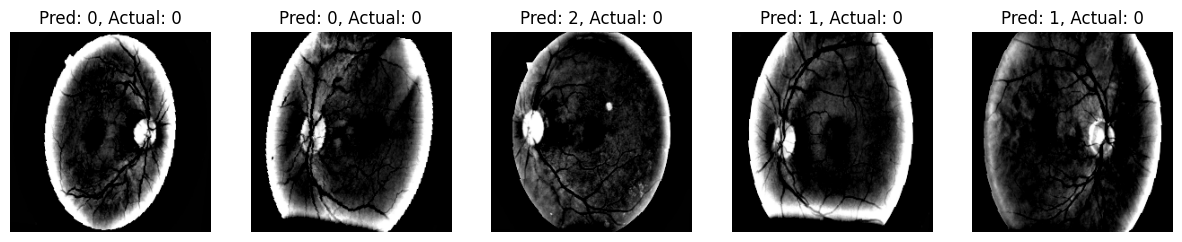

<ipython-input-16-c8973a210c34>:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 30, Loss: 0.02787747740983511, Train Accuracy: 0.9903
Precision: 0.9903, Recall: 0.9903, F1-score: 0.9903
Test Accuracy: 0.8664
Precision: 0.8688, Recall: 0.8664, F1-score: 0.8668


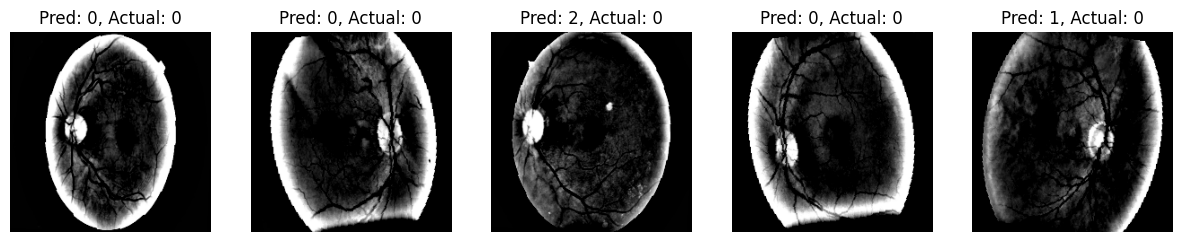

In [20]:
train(model, train_loader, val_loader, epochs=30)

In [21]:
torch.save(model.state_dict(), '/content/model.pth')

### Visualizations


In [22]:
def plot_training_results():
    df = pd.read_csv("training_results.csv")
    plt.figure(figsize=(10, 5))
    plt.plot(df['Epoch'], df['Accuracy'], label='Accuracy')
    plt.plot(df['Epoch'], df['Loss'], label='Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.legend()
    plt.title('Training Performance')
    plt.show()

In [28]:
def plot_classification_results():
    df = pd.read_csv("classification_results.csv")
    plt.figure(figsize=(6, 4))
    plt.hist(df['Actual'], bins=50, alpha=0.5, label='Actual')
    plt.hist(df['Predicted'], bins=50, alpha=0.5, label='Predicted')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.legend()
    plt.title('Classification Distribution')
    plt.show()

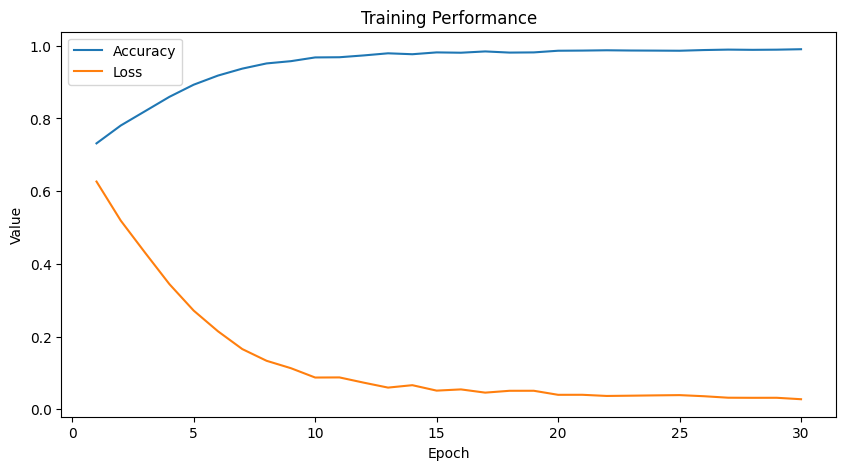

In [24]:
plot_training_results()


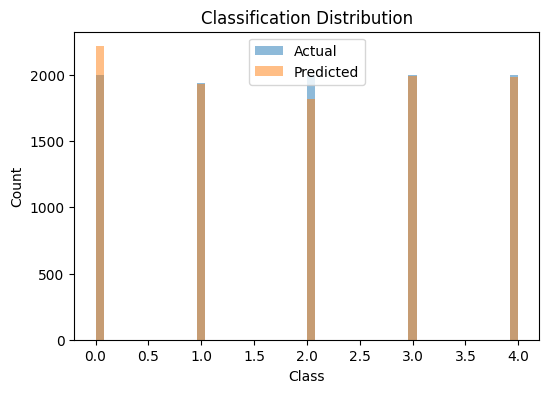

In [29]:
plot_classification_results()